# CS 5665 - Introduction to Data Science


## Introduction


The data used in this project is from [this](https://www.kaggle.com/c/linking-writing-processes-to-writing-quality).


### Introducing the dataset and packages


In [16]:
# Import packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [17]:
# Import dataset
train_df = pd.read_csv('../data/train_logs.csv')
train_scores = pd.read_csv('../data/train_scores.csv')
test_logs = pd.read_csv('../data/test_logs.csv')

In [18]:
train_df = train_df.merge(train_scores, on='id')

## Data Exploration


We are going to summarize the events per student (_id_) and use that as our new dataset. This will require exploring the data to see how to interpret the categorical variables and sum the numerical variables. We will start by evaluating the time dependent variables, the other numerical variables, and last the categorical variables.


In [19]:
train_df

In [ ]:
train_df.describe()

,event_id,down_time,up_time,action_time,cursor_position,word_count,score
count,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06,8.405898e+06
mean,2.067649e+03,7.935603e+05,7.936584e+05,9.808498e+01,1.222964e+03,2.314687e+02,3.992162e+00
std,1.588284e+03,5.149451e+05,5.149428e+05,2.533985e+02,9.485242e+02,1.759088e+02,9.918788e-01
min,1.000000e+00,1.060000e+02,2.520000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01
25%,8.520000e+02,3.731842e+05,3.732820e+05,6.600000e+01,4.990000e+02,9.600000e+01,3.500000e+00
50%,1.726000e+03,7.208860e+05,7.209800e+05,9.300000e+01,1.043000e+03,2.000000e+02,4.000000e+00
75%,2.926000e+03,1.163042e+06,1.163141e+06,1.220000e+02,1.706000e+03,3.270000e+02,4.500000e+00
max,1.287600e+04,8.313630e+06,8.313707e+06,4.474700e+05,7.802000e+03,1.326000e+03,6.000000e+00


### _down_time_, _up_time_, _action_time_ analysis


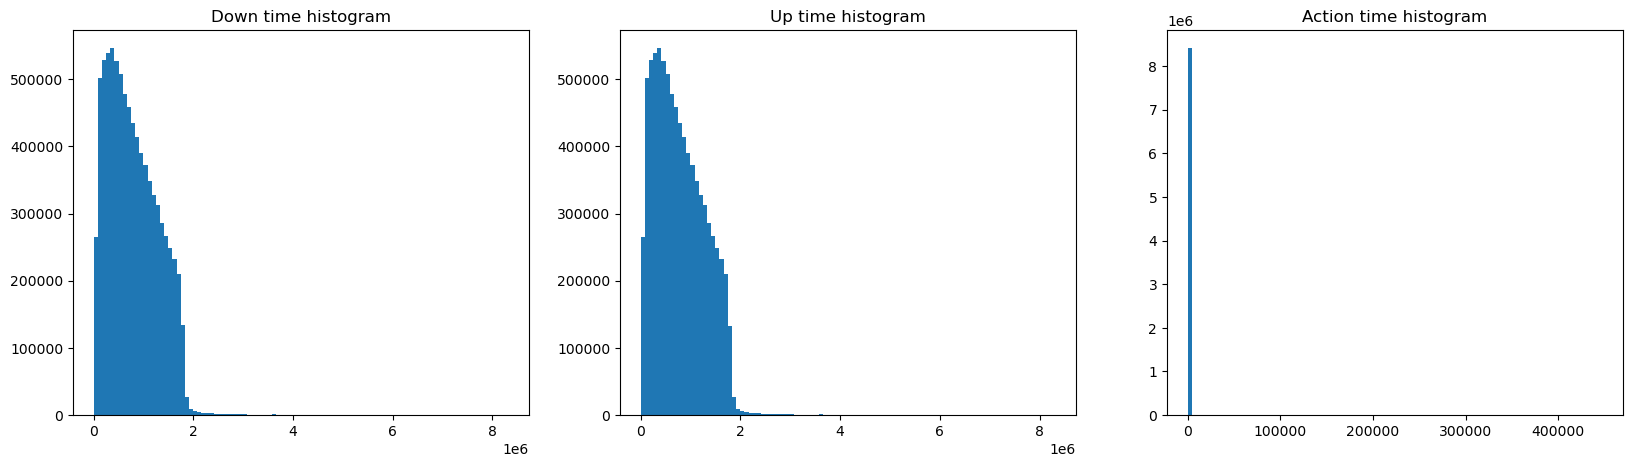

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(train_df['down_time'], bins=100)
plt.title('Down time histogram')
plt.subplot(1, 3, 2)
plt.hist(train_df['up_time'], bins=100)
plt.title('Up time histogram')
plt.subplot(1, 3, 3)
plt.hist(train_df['action_time'], bins=100)
plt.title('Action time histogram')
plt.show()

C:\Users\sarad\AppData\Local\Temp\ipykernel_41720\3843834173.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_df = temp_df.groupby('id').mean()


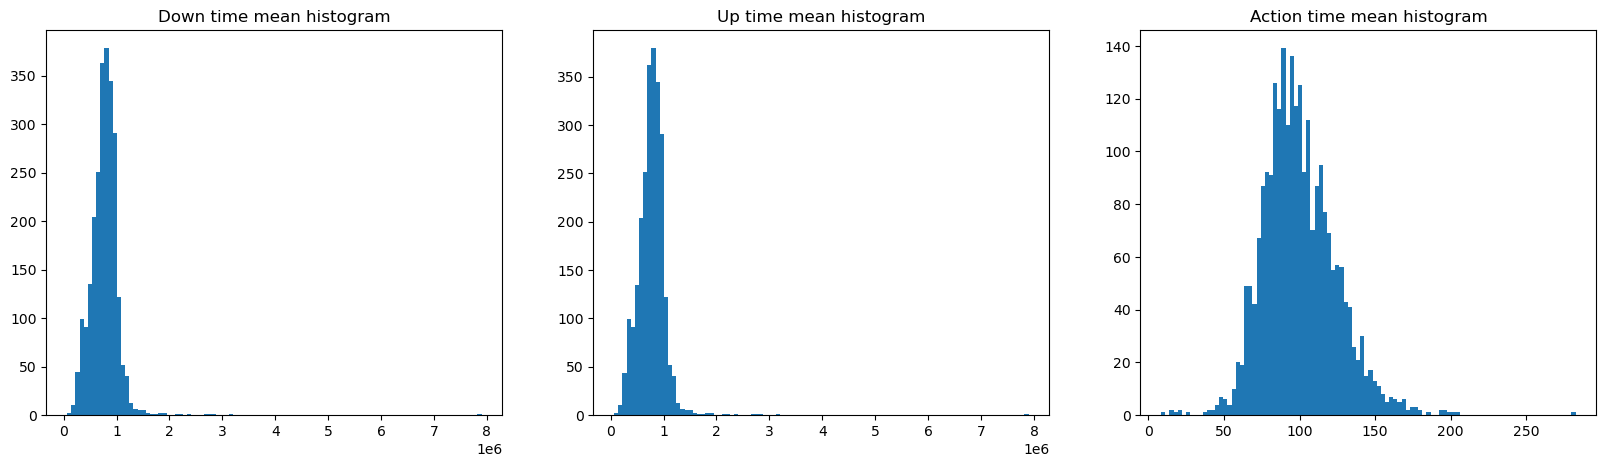

In [ ]:
temp_df = train_df.copy(deep=True)
temp_df = temp_df.groupby('id').mean()
temp_df.drop(columns=['event_id'], inplace=True)
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.hist(temp_df['down_time'], bins=100)
plt.title('Down time mean histogram')
plt.subplot(1, 3, 2)
plt.hist(temp_df['up_time'], bins=100)
plt.title('Up time mean histogram')
plt.subplot(1, 3, 3)
plt.hist(temp_df['action_time'], bins=100)
plt.title('Action time mean histogram')
plt.show()

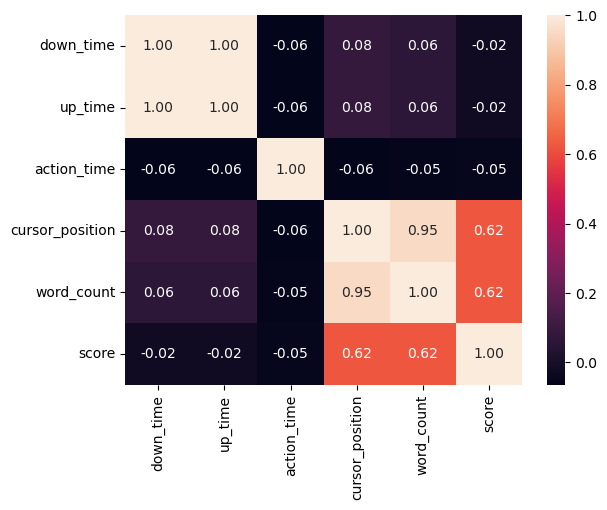

In [ ]:

# find correlation between features and target
corr_matrix = temp_df.corr()

# Show a visual matrix using seaborn heatmap
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

plt.show()

_down_time_, _up_time_, _action_time_ will be kept, grouped by _id_, and averaged.


### _cursor_position_ and _word_count_ analysis


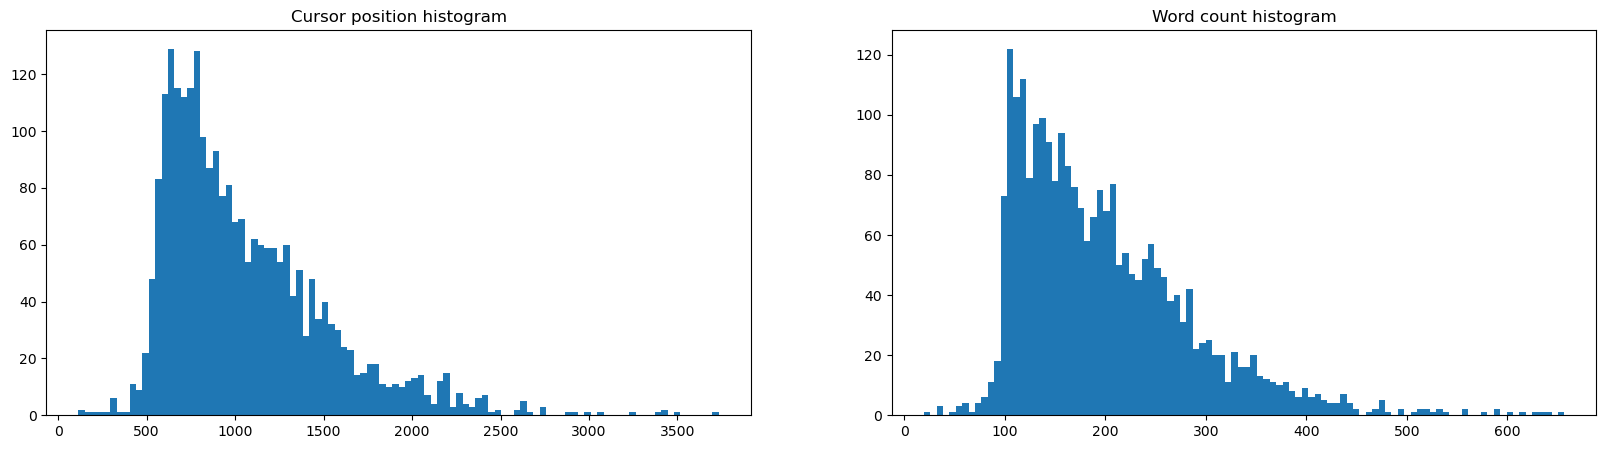

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(temp_df['cursor_position'], bins=100)
plt.title('Cursor position histogram')
plt.subplot(1, 2, 2)
plt.hist(temp_df['word_count'], bins=100)
plt.title('Word count histogram')
plt.show()

_cursor_position_ and _word_count_ will be kept, grouped by _id_, and averaged.


### Categorical variable analysis (_activity_, _up_event_, _down_event_, and _text_change_)


In [ ]:
subset = train_df[['id', 'score']]

<Axes: >

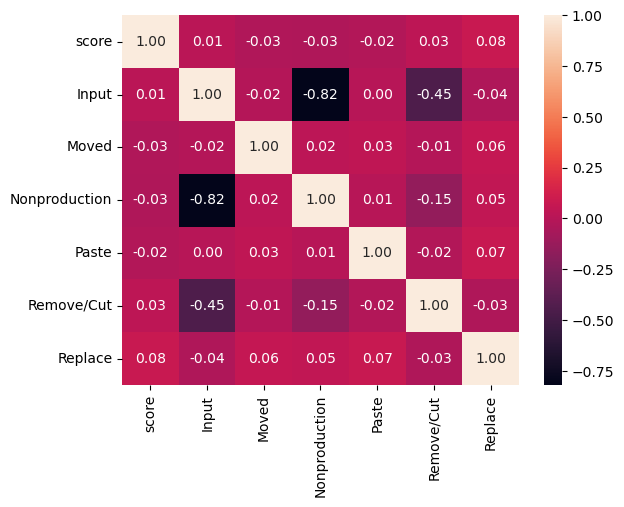

In [ ]:
# Test to see if one-hot encoded would be suitable for the activity column
train_df.loc[train_df['activity'].str.contains('Move From '), 'activity'] = 'Moved'
activity_test = pd.concat([subset, pd.get_dummies(train_df['activity'])], axis=1).groupby('id').mean()
sns.heatmap(activity_test.corr(), annot=True, fmt=".2f")

In [ ]:
display(pd.DataFrame(train_df['down_event'].value_counts()).T)
display(pd.DataFrame(train_df['up_event'].value_counts()).T)
display(pd.DataFrame(train_df['text_change'].value_counts()).T)

In [ ]:
# Test to see if up_event is suitable for one-hot encoding, and remove the ones that rare event occurances (less than 10000)
up_event = train_df['up_event'].value_counts()
up_event = up_event[up_event > 10000]
train_df.loc[~train_df['up_event'].isin(up_event.index), 'up_event'] = 'Rare'
up_event_test = pd.concat([subset, pd.get_dummies(train_df['up_event'])], axis=1).groupby('id').mean()
sns.heatmap(up_event_test.corr(), annot=True, fmt=".2f")

In [14]:
# Repeat the same for up_event
down_event = train_df['down_event'].value_counts()
down_event = down_event[down_event > 10000]
train_df.loc[~train_df['down_event'].isin(down_event.index), 'down_event'] = 'Rare'
down_event_test = pd.concat([subset, pd.get_dummies(train_df['down_event'])], axis=1).groupby('id').mean()
sns.heatmap(down_event_test.corr(), annot=True, fmt=".2f")

Repeated analysis, and tedious which is why it has been removed, for text_change show that data augmentation was not helpful and this variable could be dropped. 

### Cleaning Data

Before we can split, we need to convert the keystroke measurements to the appropriate metrics for each user. Due to these metric types originally being event dependent, we will be dropping 'cursor_position', 'down_event', 'up_event', and 'text_change.'


In [ ]:
# _down_time_, _up_time_, _action_time_ will be kept, grouped by _id_, and averaged.
train_df_cleaned = train_df.groupby('id').mean()
train_df_cleaned.drop(columns=['event_id'], inplace=True)

# _activity_ will be one-hot encoded, grouped by _id_, and averaged.
#_cursor_position_ and _word_count_ will be kept, grouped by _id_, and averaged.


In [ ]:
cleaned_train = train_df.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby('id').sum()
cleaned_train = cleaned_train.merge(train_scores, on='id')

cleaned_prediction_test = test_logs.drop(columns=['cursor_position','down_event', 'up_event','text_change']).groupby('id').sum().reset_index()

### Preprocessing


In [ ]:
# Identify numeric feature statistics
cleaned_train.info()
cleaned_train.describe(include='all')

# Checking for missing values
cleaned_train.describe(include="all").loc['count']

In [ ]:
passthrough_variables = ['id', 'score']
scale_variables = ['event_id', 'down_time', 'up_time', 'action_time', 'word_count']

In [ ]:
preprocessor = make_column_transformer(
    ("passthrough", passthrough_variables),
    (StandardScaler(), scale_variables)
)

In [ ]:
transformed = preprocessor.fit_transform(cleaned_train)
column_names = passthrough_variables + scale_variables

In [ ]:
X_trained_transformed = pd.DataFrame(transformed, columns=column_names)
X_trained_transformed

### Splitting Data


In [ ]:
# for run time consistency, set seed
np.random.seed(42)
train_df, test_df = train_test_split(X_trained_transformed, test_size=0.2, random_state=42)


In [ ]:
# Scaling prediction test data
passthrough_variables = ['id']
scale_variables = ['event_id', 'down_time', 'up_time', 'action_time', 'word_count']

preprocessor = make_column_transformer(
    ("passthrough", passthrough_variables),
    (StandardScaler(), scale_variables)
)

transformed = preprocessor.fit_transform(cleaned_prediction_test)
column_names = passthrough_variables + scale_variables

prediction_test_transformed = pd.DataFrame(transformed, columns=column_names)

### Dummy Submission


In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(train_df.drop(columns=['score']), train_df['score'])

In [ ]:
# Predict
prediction = pd.DataFrame()
prediction['id'] = cleaned_prediction_test.index
prediction ['score']= dummy_clf.predict(cleaned_prediction_test)
print(prediction.info())

prediction.to_csv('../data/prediction.csv', index=False)

## Non-Dummy Submission Checkpoint 2 (1)


In [ ]:
clf_2_1 = LinearRegression()
clf_2_1.fit(train_df.drop(columns=['score', 'id']), train_df['score'])

In [ ]:
# Predict
prediction = pd.DataFrame()
prediction['id'] = prediction_test_transformed['id']
prediction ['score'] = clf_2_1.predict(prediction_test_transformed.drop(columns=['id']))

prediction.to_csv('../data/prediction_2_1.csv', index=False)

prediction

## Dummy Submission Checkpoint 2 (2)


In [ ]:
clf_2_2 = RandomForestRegressor(random_state=48)
clf_2_2.fit(train_df.drop(columns=['score', 'id']), train_df['score'])

In [ ]:
# Predict
prediction = pd.DataFrame()
prediction['id'] = prediction_test_transformed['id']
prediction ['score'] = clf_2_2.predict(prediction_test_transformed.drop(columns=['id']))

prediction.to_csv('../data/prediction_2_2.csv', index=False)

prediction